# Analysis

In [17]:
# ruff: noqa
%reload_ext autoreload
%autoreload 2

# Standard imports
import os

# External imports
import hydra
import rootutils
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wandb.sdk.wandb_run import Run

import wandb

In [18]:
# Reinitialize hydra on every run
hydra.core.global_hydra.GlobalHydra.instance().clear()
h = hydra.initialize(config_path="../conf", job_name="eda", version_base=None)

# Setup root environment
root_path = rootutils.setup_root(".")
rootutils.set_root(
    path=root_path,
    project_root_env_var=True,
)

In [19]:
# Global paths
ROOT_DIR = root_path
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

In [20]:
# Global Labeling
rename_dict = {
    "exp1-pretrained": "Pretrained",
    "exp1-human": "Human",
    "exp1-gpt3.5-zeroshot-context1": "GPT-3.5 +\n0-shot +\nContext 1",
    "exp1-gpt3.5-zeroshot-context2": "GPT-3.5 +\n0-shot +\nContext 2",
    "exp1-gpt3.5-zeroshot-context3": "GPT-3.5 +\n0-shot +\nContext 3",
    "exp1-gpt3.5-oneshot-context1": "GPT-3.5 +\n1-shot +\nContext 1",
    "exp1-gpt3.5-oneshot-context2": "GPT-3.5 +\n1-shot +\nContext 2",
    "exp1-gpt3.5-oneshot-context3": "GPT-3.5 +\n1-shot +\nContext 3",
}

def rename(x):
    return rename_dict.get(x, x)

In [21]:
# Style and colors
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [22]:
# Initialise W&B
# Initialize wandb
WANDB_PROJECT = "homepage2vec"
WANDB_ENTITY = "ml-project-2-mlp"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
print(f"✅ Loaded {len(runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT})")

✅ Loaded 30 runs from W&B (ml-project-2-mlp/homepage2vec)


In [23]:
# Helpers
def runs_to_df(runs: list[Run]) -> pd.DataFrame:
    """
    Convert a list of W&B runs to a dataframe.
    """
    rows = []
    data_attr = ["name"]
    labeler_attr = ["name", "model", "fewshot", "features"]
    for run in runs[::-1]:
        data = {f"data_{k}":v for k,v  in run.config.get("data", {}).items() if k in data_attr}
        labeler = {f"labeler_{k}":v for k,v  in run.config.get("labeler", {}).items() if k in labeler_attr}
        hparams = {
            "lr": run.config.get("model", {}).get("optimizer", {}).get("lr", None),
            "weight_decay": run.config.get("model", {}).get("optimizer", {}).get("weight_decay", None),
            "scheduler_factor": run.config.get("model", {}).get("scheduler", {}).get("factor", None),
            "batch_size": run.config.get("datamodule", {}).get("batch_size", None),
        }
        config = {"id": run.id, "name": run.name, "finetune": run.config["finetune"], **data, **labeler, **hparams}
        summary = {k:v for k, v in run.summary.items() if not k.startswith("_")}
        row = {**config, **hparams, **summary}
        rows.append(row)

    # Add multi-index
    columns = list(config.keys()) + list(hparams.keys()) + list(summary.keys())
    config_tuples = [("config", k) for k in config.keys()]
    hparams_tuples = [("hparams", k) for k in hparams.keys()]
    summary_tuples = [("summary", k) for k in summary.keys()]

    # Create dataframe
    run_df = pd.DataFrame(rows, columns=columns)
    run_df.columns = pd.MultiIndex.from_tuples(
        config_tuples + hparams_tuples + summary_tuples,
    )
    run_df.set_index(("config", "id"), inplace=True)

    return run_df

In [24]:
def best_runs(df_runs: pd.DataFrame, metric: str="f1") -> pd.DataFrame:
    """
    Get the best runs based on the validation metric for 
    each unique combination of data, labeler - specified 
    in the run name.

    Args:
        df_runs (pd.DataFrame): Dataframe of runs.
        metric (str): Metric to sort on.

    Returns:
        pd.DataFrame: Dataframe of best runs.
    """
    unique_runs = df_runs[("config", "name")].unique()
    best_runs = []
    for unique_run in unique_runs:
        is_unique_run = df_runs[("config", "name")] == unique_run
        best_unique_run = df_runs[is_unique_run].sort_values(("summary", f"val/{metric}"), ascending=False).iloc[0]
        best_runs.append(best_unique_run)

    return pd.DataFrame(best_runs)

## Experiment 1: Fine-tuning on `original`

---

In this experiment we are verifying the annotation quality of the various `labelers` (specified in `conf/labelers`) by fine-tuning models on the `original` dataset with the labels provided by each labeler. The training parameters are kept constant for all the experiments.

In [25]:
# Filter runs for Experiment 1
GROUP = "exp1"

exp1_runs = [run for run in runs if run.group == GROUP]

print(f"✅ Loaded {len(exp1_runs)} runs from W&B ({WANDB_ENTITY}/{WANDB_PROJECT} - {GROUP})")

✅ Loaded 8 runs from W&B (ml-project-2-mlp/homepage2vec - exp1)


In [26]:
# Convert to dataframe
exp1_runs_df = runs_to_df(exp1_runs)

exp1_runs_df.tail(5)

config                     \
                                       name finetune data_name   
(config, id)                                                     
bxuwsqnk       exp1-gpt3.5-oneshot-context1     True  original   
9854g01m      exp1-gpt3.5-zeroshot-context2     True  original   
iaktc4wf       exp1-gpt3.5-oneshot-context2     True  original   
m5s43vm4      exp1-gpt3.5-zeroshot-context3     True  original   
20a3xvb9       exp1-gpt3.5-oneshot-context3     True  original   

                                                                            \
                          labeler_name       labeler_model labeler_fewshot   
(config, id)                                                                 
bxuwsqnk       gpt3.5-oneshot-context1  gpt-3.5-turbo-1106            True   
9854g01m      gpt3.5-zeroshot-context2  gpt-3.5-turbo-1106           False   
iaktc4wf       gpt3.5-oneshot-context2  gpt-3.5-turbo-1106            True   
m5s43vm4      gpt3.5-zeroshot-context3  gpt-3.5-turbo-1106           False   
20a3xvb9       gpt3.5-oneshot-context3  gpt-3.5-turbo-1106            True   

                                                                        \
                                               labeler_features     lr   
(config, id)                                                             
bxuwsqnk                                [tld, domain, metatags]  0.001   
9854g01m      [tld, domain, metatags, title, description, ke...  0.001   
iaktc4wf      [tld, domain, metatags, title, description, ke...  0.001   
m5s43vm4      [tld, domain, metatags, title, description, ke...  0.001   
20a3xvb9      [tld, domain, metatags, title, description, ke...  0.001   

                                            ...     summary                 \
             weight_decay scheduler_factor  ... test/recall test/precision   
(config, id)                                ...                              
bxuwsqnk                0              0.1  ...    0.117432       0.649590   
9854g01m                0              0.1  ...    0.235549       0.600397   
iaktc4wf                0              0.1  ...    0.276708       0.573738   
m5s43vm4                0              0.1  ...    0.278247       0.566276   
20a3xvb9                0              0.1  ...    0.282138       0.576649   

                                                            \
             epoch  test/lpp  train/f1 train/acc   test/f1   
(config, id)                                                 
bxuwsqnk         0  0.445415  0.850748  0.988565  0.179938   
9854g01m         0  0.986900  0.883396  0.978697  0.321358   
iaktc4wf         0  1.131004  0.845440  0.964756  0.359323   
m5s43vm4         0  1.148472  0.889730  0.976504  0.354613   
20a3xvb9         0  1.139738  0.782953  0.950971  0.359856   

                                                      
             trainer/global_step   val/acc  test/acc  
(config, id)                                          
bxuwsqnk                       0  0.935150  0.830318  
9854g01m                       0  0.936090  0.822832  
iaktc4wf                       0  0.916353  0.822520  
m5s43vm4                       0  0.918233  0.822208  
20a3xvb9                       0  0.906015  0.828447  

[5 rows x 30 columns]

In [27]:
exp1_best_runs_df = best_runs(exp1_runs_df)

exp1_best_runs_df

config                     \
                                   name finetune data_name   
ahvkq0z1                exp1-pretrained    False  original   
cbshkcrr                     exp1-human     True  original   
xl3pk6r7  exp1-gpt3.5-zeroshot-context1     True  original   
bxuwsqnk   exp1-gpt3.5-oneshot-context1     True  original   
9854g01m  exp1-gpt3.5-zeroshot-context2     True  original   
iaktc4wf   exp1-gpt3.5-oneshot-context2     True  original   
m5s43vm4  exp1-gpt3.5-zeroshot-context3     True  original   
20a3xvb9   exp1-gpt3.5-oneshot-context3     True  original   

                                                                        \
                      labeler_name       labeler_model labeler_fewshot   
ahvkq0z1                     human                 NaN             NaN   
cbshkcrr                     human                 NaN             NaN   
xl3pk6r7  gpt3.5-zeroshot-context1  gpt-3.5-turbo-1106           False   
bxuwsqnk   gpt3.5-oneshot-context1  gpt-3.5-turbo-1106            True   
9854g01m  gpt3.5-zeroshot-context2  gpt-3.5-turbo-1106           False   
iaktc4wf   gpt3.5-oneshot-context2  gpt-3.5-turbo-1106            True   
m5s43vm4  gpt3.5-zeroshot-context3  gpt-3.5-turbo-1106           False   
20a3xvb9   gpt3.5-oneshot-context3  gpt-3.5-turbo-1106            True   

                                                                    \
                                           labeler_features     lr   
ahvkq0z1                                                NaN  0.001   
cbshkcrr                                                NaN  0.001   
xl3pk6r7                            [tld, domain, metatags]  0.001   
bxuwsqnk                            [tld, domain, metatags]  0.001   
9854g01m  [tld, domain, metatags, title, description, ke...  0.001   
iaktc4wf  [tld, domain, metatags, title, description, ke...  0.001   
m5s43vm4  [tld, domain, metatags, title, description, ke...  0.001   
20a3xvb9  [tld, domain, metatags, title, description, ke...  0.001   

                                        ...     summary                       \
         weight_decay scheduler_factor  ... test/recall test/precision epoch   
ahvkq0z1            0              0.1  ...    0.389187       0.440303     0   
cbshkcrr            0              0.1  ...    0.334398       0.472259     0   
xl3pk6r7            0              0.1  ...    0.091174       0.618475     0   
bxuwsqnk            0              0.1  ...    0.117432       0.649590     0   
9854g01m            0              0.1  ...    0.235549       0.600397     0   
iaktc4wf            0              0.1  ...    0.276708       0.573738     0   
m5s43vm4            0              0.1  ...    0.278247       0.566276     0   
20a3xvb9            0              0.1  ...    0.282138       0.576649     0   

                                                                      \
          test/lpp  train/f1 train/acc   test/f1 trainer/global_step   
ahvkq0z1  1.768559       NaN       NaN  0.400624                   0   
cbshkcrr  1.318777  0.735036  0.917606  0.380334                   0   
xl3pk6r7  0.231441  0.736341  0.989818  0.147396                   0   
bxuwsqnk  0.445415  0.850748  0.988565  0.179938                   0   
9854g01m  0.986900  0.883396  0.978697  0.321358                   0   
iaktc4wf  1.131004  0.845440  0.964756  0.359323                   0   
m5s43vm4  1.148472  0.889730  0.976504  0.354613                   0   
20a3xvb9  1.139738  0.782953  0.950971  0.359856                   0   

                              
           val/acc  test/acc  
ahvkq0z1       NaN  0.799439  
cbshkcrr  0.824248  0.825951  
xl3pk6r7  0.967105  0.818465  
bxuwsqnk  0.935150  0.830318  
9854g01m  0.936090  0.822832  
iaktc4wf  0.916353  0.822520  
m5s43vm4  0.918233  0.822208  
20a3xvb9  0.906015  0.828447  

[8 rows x 30 columns]

In [28]:
# Evaluate remaining runs from bash script
# os.system(f"../eval.sh {' '.join(list(exp1_best_runs_df.index))}")

In [29]:
# Reload runs and df
api = wandb.Api()
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

exp1_runs = [run for run in runs if run.group == GROUP]
exp1_runs_df = runs_to_df(exp1_runs)
exp1_best_runs_df = best_runs(exp1_runs_df)

In [30]:
# Top-5 runs
top_k = 5
exp1_best_runs_df.sort_values(by=("summary", "val/f1"), ascending=False).head(top_k)[["config", "summary"]]

config                     \
                                   name finetune data_name   
m5s43vm4  exp1-gpt3.5-zeroshot-context3     True  original   
20a3xvb9   exp1-gpt3.5-oneshot-context3     True  original   
9854g01m  exp1-gpt3.5-zeroshot-context2     True  original   
iaktc4wf   exp1-gpt3.5-oneshot-context2     True  original   
cbshkcrr                     exp1-human     True  original   

                                                                        \
                      labeler_name       labeler_model labeler_fewshot   
m5s43vm4  gpt3.5-zeroshot-context3  gpt-3.5-turbo-1106           False   
20a3xvb9   gpt3.5-oneshot-context3  gpt-3.5-turbo-1106            True   
9854g01m  gpt3.5-zeroshot-context2  gpt-3.5-turbo-1106           False   
iaktc4wf   gpt3.5-oneshot-context2  gpt-3.5-turbo-1106            True   
cbshkcrr                     human                 NaN             NaN   

                                                                    \
                                           labeler_features     lr   
m5s43vm4  [tld, domain, metatags, title, description, ke...  0.001   
20a3xvb9  [tld, domain, metatags, title, description, ke...  0.001   
9854g01m  [tld, domain, metatags, title, description, ke...  0.001   
iaktc4wf  [tld, domain, metatags, title, description, ke...  0.001   
cbshkcrr                                                NaN  0.001   

                                        ...     summary                        \
         weight_decay scheduler_factor  ... test/recall val/f1_best  test/lpp   
m5s43vm4            0              0.1  ...    0.278247    0.602366  1.148472   
20a3xvb9            0              0.1  ...    0.282138    0.512322  1.139738   
9854g01m            0              0.1  ...    0.235549    0.481021  0.986900   
iaktc4wf            0              0.1  ...    0.276708    0.503938  1.131004   
cbshkcrr            0              0.1  ...    0.334398    0.432483  1.318777   

                                                                             
         train/acc test/loss train/loss epoch   test/f1  test/acc  train/f1  
m5s43vm4  0.976504  0.745897   0.062158     0  0.354613  0.822208  0.889730  
20a3xvb9  0.950971  0.601387   0.120035     0  0.359856  0.828447  0.782953  
9854g01m  0.978697  0.801128   0.058104     0  0.321358  0.822832  0.883396  
iaktc4wf  0.964756  0.678047   0.090516     0  0.359323  0.822520  0.845440  
cbshkcrr  0.917606  0.458644   0.181722     0  0.380334  0.825951  0.735036  

[5 rows x 26 columns]

✅ Saved figure to /Users/jonas-mika/epfl/coursework/projects/ml-project-2-mlp/report/figures


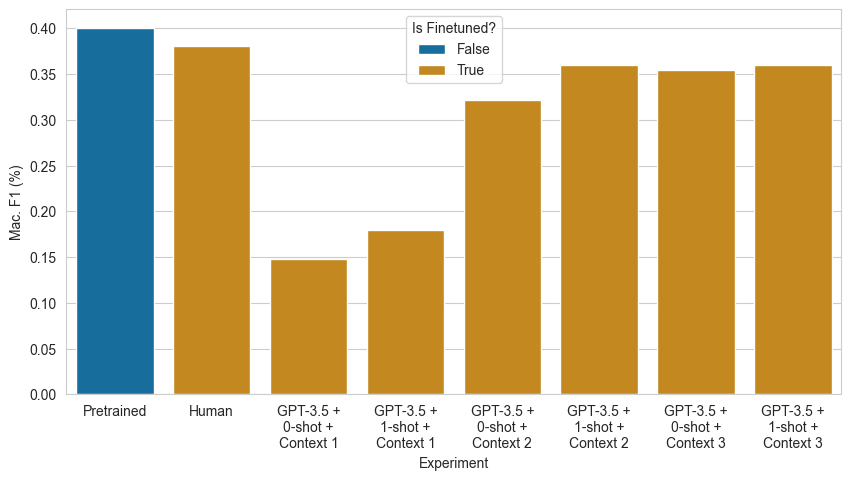

In [33]:
# Visualise best runs
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=exp1_best_runs_df,
    x=("config", "name"),
    y=("summary", "test/f1"),
    hue=("config", "finetune"),
    ax=ax
)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([rename(x.get_text()) for x in ax.get_xticklabels()])
ax.set_xlabel("Experiment")
ax.set_ylabel("Mac. F1 (%)")
ax.get_legend().set_title("Is Finetuned?")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "exp1_runs.pdf"), dpi=300, bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}")

## Experiment 2: Fine-tuning on `curlie-10000`

In [32]:
# TODO